<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/DenseNetModelStats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# Dataset

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-05-28 09:28:38--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-28 09:28:38--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [          <=>       ]  33.20M  16.1MB/s    in 2.1s    

2021-05-28 09:28:41 (16.1 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz

In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [6]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

In [7]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
test_dataset = TensorDataset(test_input,test_target , test_classes)

# model

## FCNN

In [8]:
class FCNN_1LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_1LAYER, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(2*14*14, nb_n)
        self.fc1 = nn.Linear(nb_n, 1)
        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = self.fc1(x)
        
        return torch.sigmoid(x)

class FCNN_2LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_2LAYER, self).__init__()


        self.input = nn.Linear(2*14*14, 300)
        self.fc1 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, 1)
        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = torch.relu( self.fc1(x) )
        x = self.fc2(x)
        
        return torch.sigmoid(x)

class FCNN_3LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_3LAYER, self).__init__()


        self.input = nn.Linear(2*14*14, 300)
        self.fc1 = nn.Linear(300, 150)
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, 1)

        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = self.fc3(x)
        
        return torch.sigmoid(x)

class FCNN_4LAYER(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_4LAYER, self).__init__()


        self.input = nn.Linear(2*14*14, 300)
        self.fc1 = nn.Linear(300, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 1)

        

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.input(x) )
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = self.fc4(x)
        
        return torch.sigmoid(x)



class FCNN_image_specific(nn.Module):
    def __init__(self , **kwargs):
        super(FCNN_image_specific, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.inputR = nn.Linear(14*14, nb_n)
        self.inputL = nn.Linear(14*14, nb_n)
        self.fc1R = nn.Linear(nb_n, 10)
        self.fc1L = nn.Linear(nb_n, 10)
        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, 1)


    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.inputL( nn.Flatten(1)(x_l) ) )
        x_l = torch.relu( self.fc1L( x_l) ) 

        x_r = torch.relu( self.inputR(nn.Flatten(1)(x_r)) )
        x_r = torch.relu( self.fc1R(x_r) ) 

        x = torch.relu(self.fc2(torch.cat([x_l , x_r], 1)))
        x = self.fc3(x)
        return torch.sigmoid(x)

## WS

In [9]:
class WS_FCNN_image_specific1(nn.Module):
    def __init__(self , **kwargs):
        super(WS_FCNN_image_specific1, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(14*14, nb_n)
        self.fc1 = nn.Linear(nb_n, 10)

        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, 1)

    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.input( nn.Flatten(1)(x_l) ) )
        x_l = torch.relu( self.fc1( x_l) ) 

        x_r = torch.relu( self.input(nn.Flatten(1)(x_r)) )
        x_r = torch.relu( self.fc1(x_r) ) 

        x = torch.relu(self.fc2(torch.cat([x_l , x_r], 1)))
        x = self.fc3(x)
        return torch.sigmoid(x)



class CNN_image_specific1(nn.Module):
    def __init__(self ,  **kwargs):
        super(CNN_image_specific1, self).__init__()

        self.conv1l = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2l = nn.Conv2d(5, 8, kernel_size=3)

        self.fc3l = nn.Linear(800, 200)
        self.fc4l = nn.Linear(200, 10)

        self.conv1r = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2r = nn.Conv2d(5, 8, kernel_size=3)

        self.fc3r = nn.Linear(800, 200)
        self.fc4r = nn.Linear(200, 10)

        self.fc5 = nn.Linear(20, 15)
        self.fc6 = nn.Linear(15, 1)
        
    def forward(self, x):

        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)
        
        x_l = F.relu(self.conv1l(x_l))
        x_r = F.relu(self.conv1r(x_r))

        x_l = F.relu(self.conv2l(x_l))
        x_r = F.relu(self.conv2r(x_r))

        x_l = nn.Flatten(1)(x_l)
        x_r = nn.Flatten(1)(x_r)

        #print(x1.shape)
        x_l = F.relu(self.fc3l(x_l))
        x_r = F.relu(self.fc3r(x_r))

        x_l = self.fc4l(x_l)
        x_r = self.fc4r(x_r)

        x = F.relu(self.fc5(torch.cat((
            F.relu(x_l),
            F.relu(x_r)
            ), 1)))
        x = self.fc6(x)

        return torch.sigmoid(x)


class WS_CNN_image_specific1(nn.Module):
    def __init__(self ,  **kwargs):
        super(WS_CNN_image_specific1, self).__init__()

        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 8, kernel_size=3)

        self.fc3 = nn.Linear(800, 200)
        self.fc4 = nn.Linear(200, 10)

        self.fc5 = nn.Linear(20, 15)
        self.fc6 = nn.Linear(15, 1)
        
    def forward(self, x):

        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)
        
        x_l = F.relu(self.conv1(x_l))
        x_r = F.relu(self.conv1(x_r))

        x_l = F.relu(self.conv2(x_l))
        x_r = F.relu(self.conv2(x_r))

        x_l = nn.Flatten(1)(x_l)
        x_r = nn.Flatten(1)(x_r)

        #print(x1.shape)
        x_l = F.relu(self.fc3(x_l))
        x_r = F.relu(self.fc3(x_r))

        x_l = self.fc4(x_l)
        x_r = self.fc4(x_r)

        x = F.relu(self.fc5(torch.cat((
            F.relu(x_l),
            F.relu(x_r)
            ), 1)))
        x = self.fc6(x)

        return torch.sigmoid(x)

## AL 

In [10]:
class AL_FCNN_image_specific(nn.Module):
    def __init__(self , **kwargs):
        super(AL_FCNN_image_specific, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.inputR = nn.Linear(14*14, nb_n)
        self.inputL = nn.Linear(14*14, nb_n)
        self.fc1R = nn.Linear(nb_n, 10)
        self.fc1L = nn.Linear(nb_n, 10)
        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, 1)


    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.inputL( nn.Flatten(1)(x_l) ) )
        x_l = self.fc1L( x_l)  

        x_r = torch.relu( self.inputR(nn.Flatten(1)(x_r)) )
        x_r = self.fc1R(x_r)  

        x = torch.relu(self.fc2(torch.cat([
                                           torch.relu(x_l) ,
                                           torch.relu(x_r)
                                           ], 1)))
        x = self.fc3(x)
        return torch.sigmoid(x) , x_l , x_r



class AL_WS_FCNN_image_specific1(nn.Module):
    def __init__(self , **kwargs):
        super(AL_WS_FCNN_image_specific1, self).__init__()

        nb_n = kwargs["nodes_nb"]

        self.input = nn.Linear(14*14, nb_n)
        self.fc1 = nn.Linear(nb_n, 10)

        self.fc2 = nn.Linear(20, 15)
        self.fc3 = nn.Linear(15, 1)

    def forward(self, x):
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu( self.input( nn.Flatten(1)(x_l) ) )
        x_l = self.fc1( x_l) 

        x_r = torch.relu( self.input(nn.Flatten(1)(x_r)) )
        x_r = self.fc1(x_r)

        x = torch.relu(self.fc2(torch.cat([
                                           torch.relu(x_l) ,
                                           torch.relu(x_r)
                                           ], 1)))
        x = self.fc3(x)
        
        
        return torch.sigmoid(x) , x_l , x_r



class AL_CNN_image_specific1(nn.Module):
    def __init__(self ,  **kwargs):
        super(AL_CNN_image_specific1, self).__init__()

        self.conv1l = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2l = nn.Conv2d(5, 8, kernel_size=3)

        self.fc3l = nn.Linear(800, 200)
        self.fc4l = nn.Linear(200, 10)

        self.conv1r = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2r = nn.Conv2d(5, 8, kernel_size=3)

        self.fc3r = nn.Linear(800, 200)
        self.fc4r = nn.Linear(200, 10)

        self.fc5 = nn.Linear(20, 15)
        self.fc6 = nn.Linear(15, 1)
        
    def forward(self, x):

        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)
        
        x_l = F.relu(self.conv1l(x_l))
        x_r = F.relu(self.conv1r(x_r))

        x_l = F.relu(self.conv2l(x_l))
        x_r = F.relu(self.conv2r(x_r))

        x_l = nn.Flatten(1)(x_l)
        x_r = nn.Flatten(1)(x_r)

        #print(x1.shape)
        x_l = F.relu(self.fc3l(x_l))
        x_r = F.relu(self.fc3r(x_r))

        x_l = self.fc4l(x_l)
        x_r = self.fc4r(x_r)

        x = F.relu(self.fc5(torch.cat((
            F.relu(x_l),
            F.relu(x_r)
            ), 1)))
        x = self.fc6(x)

        return torch.sigmoid(x) , x_l , x_r



class AL_WS_CNN_image_specific(nn.Module):
    ## lr = 0.001
    def __init__(self ,  **kwargs):
        super(AL_WS_CNN_image_specific, self).__init__()

        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        self.conv2 = nn.Conv2d(5, 8, kernel_size=3)

        self.fc3 = nn.Linear(800, 200)
        self.fc4 = nn.Linear(200, 10)

        self.fc5 = nn.Linear(20, 15)
        self.fc6 = nn.Linear(15, 1)
        
    def forward(self, x):

        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)
        
        x_l = F.relu(self.conv1(x_l))
        x_r = F.relu(self.conv1(x_r))

        x_l = F.relu(self.conv2(x_l))
        x_r = F.relu(self.conv2(x_r))

        x_l = nn.Flatten(1)(x_l)
        x_r = nn.Flatten(1)(x_r)

        #print(x1.shape)
        x_l = F.relu(self.fc3(x_l))
        x_r = F.relu(self.fc3(x_r))

        x_l = self.fc4(x_l)
        x_r = self.fc4(x_r)

        x = F.relu(self.fc5(torch.cat((
            F.relu(x_l),
            F.relu(x_r)
            ), 1)))
        x = self.fc6(x)

        return torch.sigmoid(x), x_l, x_r

# Train utils

In [11]:
def custom_loss(output, target, classes, lambda_=1.0):
  """
  Custom loss for network with auxiliary losses. The total loss is a combination
  of the loss of the main task (binary cross entropy) and the negative log likelihood
  for the two auxiliary tasks. Importance of auxiliary losses is controlled by
  the `lambda_` hyperparameter.
  """
  main, im1, im2 = output

  main_loss = F.binary_cross_entropy(main.flatten(), target)
  aux_loss_1 = F.nll_loss(im1, classes[:, 0])
  aux_loss_2 = F.nll_loss(im2, classes[:, 1])

  return main_loss + lambda_ * (aux_loss_1 + aux_loss_2)

In [12]:
def handle_loss(criterion_):
  
  """
  Handle the fact that the network with auxiliary loss has three-item tuple output,
  which needs to be treated separately to compute the loss and the accuracy.
  """
  if criterion_ is F.binary_cross_entropy:
    internal_criterion = lambda output, target, _: criterion_(output.flatten(), target)
    compute_acc = lambda output, target: (target == torch.round(output.flatten()) ).float()
  #elif criterion_ is custom_loss_copy:
  #  internal_criterion = criterion_
  #  compute_acc = lambda output, target: (target == (torch.argmax(output[0] , dim=1)).flatten() ).float()
  else:
    internal_criterion = criterion_
    compute_acc = lambda output, target: (target == torch.round(output[0].flatten()) ).float()
    
  return internal_criterion, compute_acc

In [13]:
def train_epoch(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ):
  
  internal_criterion, compute_acc = handle_loss(criterion_)

  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data)
    loss = internal_criterion(output, target.to(torch.float32), classes)
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( compute_acc(output, target) )
    
  return torch.FloatTensor(loss_tot).mean().item() , torch.cat(acc_tot).mean().item()

In [14]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  
  internal_criterion, compute_acc = handle_loss(criterion_)

  network_.eval()
  test_loss = []
  acc = []

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      loss = internal_criterion(output, target.to(torch.float32), classes)
      test_loss.append( loss.item() )
      acc.append( compute_acc(output, target) )

  
  return torch.FloatTensor(test_loss).mean().item() , torch.cat(acc).mean().item()

In [15]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):

    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# Stat train utils

In [16]:
def train_multiple_runs( network_class , runs  , epoch  , lr_  , criterion_ , **kwargs):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class(**kwargs)
    optimizer = optim.Adam(n.parameters(), lr=lr_)
    criterion = criterion_

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.append(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [17]:
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = ''):
  
  trl_mean = torch.mean(torch.tensor(all_train_loss), dim = 0)
  tra_mean = torch.mean(torch.tensor(all_train_acc), dim = 0)
  tel_mean = torch.mean(torch.tensor(all_test_loss), dim = 0)
  tea_mean = torch.mean(torch.tensor(all_test_acc), dim = 0)

  trl_std = torch.std(torch.tensor(all_train_loss), dim = 0)
  tra_std = torch.std(torch.tensor(all_train_acc), dim = 0)
  tel_std = torch.std(torch.tensor(all_test_loss), dim = 0)
  tea_std = torch.std(torch.tensor(all_test_acc), dim = 0)

  epochs = range(1, len(tea_std)+1 )

  #early_stopping = np.argmin( tel_mean )
  #print(f"at epoch {early_stopping} mean test acc : { tea_mean[early_stopping] }")
  print(f"mean last test acc : { tea_mean [-1] }")
  print(f"std  last test acc : { tea_std  [-1] }")

  temp = [ [trl_mean , trl_std , 'g' , 'trl'] ,
          [tel_mean , tel_std  , 'b' , 'tel'] ,
          [tra_mean , tra_std  , 'r' , 'tra'] ,
          [tea_mean , tea_std  , 'y' , 'tea'] ]

  if color != '':
    plt.plot( epochs , tea_mean , c=color )
    plt.fill_between(epochs, tea_mean-tea_std, tea_mean+tea_std ,alpha=0.1 , color=color )
    #plt.ylim((-0.1,1.1))
    return

  for g in temp : 
    plt.plot( epochs , g[0] , c=g[2] , label = g[3])
    plt.fill_between(epochs, g[0]-g[1], g[0]+g[1] ,alpha=0.3 , color=g[2] )

  plt.legend()
  plt.ylim((-0.1,1.1))
  plt.show()

# Testing

In [18]:
def custom_loss_BCELoss_CELoss(output, target, classes):
    
    main, im1, im2 = output

    criterion_im = nn.CrossEntropyLoss()
    criterion = F.binary_cross_entropy
    
    aux_loss_1 = criterion_im(im1, classes[:, 0].long())
    aux_loss_2 = criterion_im(im2, classes[:, 1].long())
    main_loss = criterion(main.flatten(), target) 

    return main_loss + aux_loss_1 + aux_loss_2 

In [19]:
# BATCH SIZE !
train_dataloader = DataLoader(train_dataset , batch_size=20)
test_dataloader  = DataLoader(test_dataset  , batch_size=20)

mean last test acc : 0.8884999752044678
std  last test acc : 0.004949768073856831


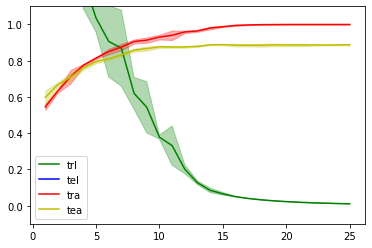

In [20]:
all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( AL_WS_FCNN_image_specific1 ,
                                                                                     runs = 2 ,
                                                                                     epoch = 25 ,
                                                                                     lr_= 0.0005 ,
                                                                                     criterion_ = custom_loss_BCELoss_CELoss,
                                                                                     nodes_nb = 1000 )
plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc )

In [21]:
RUN   = 10
EPOCH = 25

--- configuration : [1000, 0.0005, 'r', <class '__main__.WS_FCNN_image_specific1'>, <function binary_cross_entropy at 0x7f29196c58c0>]
mean last test acc : 0.829300045967102
std  last test acc : 0.009821177460253239
--- configuration : [1000, 0.0005, 'r', <class '__main__.AL_WS_FCNN_image_specific1'>, <function custom_loss_BCELoss_CELoss at 0x7f2916e199e0>]
mean last test acc : 0.8788999319076538
std  last test acc : 0.016562672331929207
--- configuration : [1000, 0.0005, 'black', <class '__main__.FCNN_image_specific'>, <function binary_cross_entropy at 0x7f29196c58c0>]
mean last test acc : 0.8237000703811646
std  last test acc : 0.007211871910840273
--- configuration : [1000, 0.0005, 'black', <class '__main__.AL_FCNN_image_specific'>, <function custom_loss_BCELoss_CELoss at 0x7f2916e199e0>]
mean last test acc : 0.8673999905586243
std  last test acc : 0.009979985654354095
--- configuration : [404, 0.0008, 'y', <class '__main__.CNN_image_specific1'>, <function binary_cross_entropy at 0x

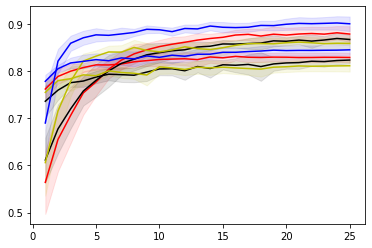

In [26]:
###########################################################################
######################### AL GRAPH ########################################
###########################################################################

stats = [
         [1000  ,0.0005  ,'r' , WS_FCNN_image_specific1       , F.binary_cross_entropy ] ,
         [1000  ,0.0005  ,'r' , AL_WS_FCNN_image_specific1    , custom_loss_BCELoss_CELoss ] ,


         [1000  ,0.0005  ,'black' , FCNN_image_specific     , F.binary_cross_entropy ] ,
         [1000  ,0.0005  ,'black' , AL_FCNN_image_specific  , custom_loss_BCELoss_CELoss ] ,


         [_     ,0.0008 , 'y' ,CNN_image_specific1          , F.binary_cross_entropy ] ,
         [_     ,0.0008 , 'y' ,AL_CNN_image_specific1       , custom_loss_BCELoss_CELoss ] ,

         [_     ,0.0013  , 'b' ,WS_CNN_image_specific1       , F.binary_cross_entropy ] ,
         [_     ,0.002  , 'b' ,AL_WS_CNN_image_specific     , custom_loss_BCELoss_CELoss ] ,
         ]

for el in stats:
  print(f'--- configuration : {el}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( el[3] ,
                                                                                     runs = RUN ,
                                                                                     epoch = EPOCH ,
                                                                                     lr_= el[1] ,
                                                                                     criterion_ = el[4],
                                                                                     nodes_nb = el[0] )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = el[2])


--- configuration : [1000, 0.0005, 'r', <class '__main__.WS_FCNN_image_specific1'>]
mean last test acc : 0.8331999778747559
std  last test acc : 0.01625424437224865
--- configuration : [1000, 0.0005, 'black', <class '__main__.FCNN_image_specific'>]
mean last test acc : 0.8144000172615051
std  last test acc : 0.017213372513651848
--- configuration : [404, 0.0008, 'y', <class '__main__.CNN_image_specific1'>]
mean last test acc : 0.813800036907196
std  last test acc : 0.019766122102737427
--- configuration : [404, 0.0012, 'b', <class '__main__.WS_CNN_image_specific1'>]
mean last test acc : 0.8378000259399414
std  last test acc : 0.006833723746240139


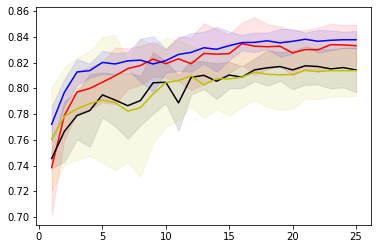

In [29]:
###########################################################################
######################### WS GRAPH ########################################
###########################################################################

stats = [
         [1000  ,0.0005  ,'r' , WS_FCNN_image_specific1] ,
         [1000  ,0.0005  ,'black' , FCNN_image_specific   ] ,
         [_     ,0.0008 , 'y' ,CNN_image_specific1 ] ,
         [_     ,0.0012 , 'b' ,WS_CNN_image_specific1 ] ,
         ]

for el in stats:
  print(f'--- configuration : {el}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( el[3] ,
                                                                                     runs = 5 ,
                                                                                     epoch = EPOCH ,
                                                                                     lr_= el[1] ,
                                                                                     criterion_ = F.binary_cross_entropy,
                                                                                     nodes_nb = el[0] )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = el[2])

--- configuration : [200, 0.001, 'r', <class '__main__.FCNN_image_specific'>]
mean last test acc : 0.8199999928474426
std  last test acc : 0.007673902437090874
--- configuration : [500, 0.001, 'r', <class '__main__.FCNN_image_specific'>]
mean last test acc : 0.8179000020027161
std  last test acc : 0.012013421393930912
--- configuration : [700, 0.0007, 'r', <class '__main__.FCNN_image_specific'>]
mean last test acc : 0.819599986076355
std  last test acc : 0.014751270413398743
--- configuration : [1000, 0.0005, 'r', <class '__main__.FCNN_image_specific'>]
mean last test acc : 0.8166000247001648
std  last test acc : 0.013351654633879662
--- configuration : [1500, 0.0002, 'r', <class '__main__.FCNN_image_specific'>]
mean last test acc : 0.8033000230789185
std  last test acc : 0.01717911846935749
--- configuration : [200, 0.0004, 'b', <class '__main__.FCNN_1LAYER'>]
mean last test acc : 0.7840999364852905
std  last test acc : 0.012431598268449306
--- configuration : [500, 0.00025, 'b', <cla

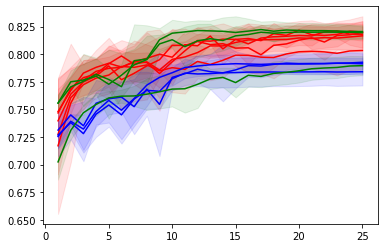

In [28]:
###########################################################################
####################### FCNN GRAPH ########################################
###########################################################################

stats = [[200  ,0.001  ,'r' , FCNN_image_specific] ,
         [500  ,0.001  ,'r' , FCNN_image_specific] ,
         [700  ,0.0007 ,'r' , FCNN_image_specific] ,
         [1000 ,0.0005 ,'r' , FCNN_image_specific] ,
         [1500 ,0.0002 ,'r' , FCNN_image_specific] ,
         
         [200 ,0.0004   ,'b', FCNN_1LAYER],
         [500 ,0.00025  ,'b', FCNN_1LAYER],
         #[700 ,0.00015  ,'b', FCNN_1LAYER],
         [1000,0.00015  ,'b', FCNN_1LAYER],

         [ _ ,0.0001 ,'g', FCNN_2LAYER],
         [ _ ,0.0005 ,'g', FCNN_3LAYER],
         [ _ ,0.0005 ,'g', FCNN_4LAYER]
         
         ]

for el in stats:
  print(f'--- configuration : {el}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( el[3] ,
                                                                                     runs = RUN ,
                                                                                     epoch = EPOCH ,
                                                                                     lr_= el[1] ,
                                                                                     criterion_ = F.binary_cross_entropy,
                                                                                     nodes_nb = el[0] )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc , color = el[2])

In [25]:
## Brute force lr investigation

'''
for lr in [0.00005 , 0.00007 , 0.0001 , 0.00015 , 0.0002 , 0.00025 , 0.0003 , 0.0004]:
  print(f'at LR = {lr}')
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = train_multiple_runs( WS_CNN_image_specific ,
                                                                                     runs = 1 ,
                                                                                     epoch = 25 ,
                                                                                     lr_= lr ,
                                                                                     criterion_ = F.binary_cross_entropy,
                                                                                     nodes_nb = _ )
  plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc)
  '''


404

404